# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [2]:

#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("totally_processed_DB.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
final = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
final.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary,Combined_Reviews
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ,witti littl book make son laugh loud recit car...
1,1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...,love the book miss the hard cover version,grew read sendak book watch realli rosi movi i...
2,2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...,chicken soup with rice month,fun way children learn month year learn poem t...
3,3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read aloud nice rhythm well g...,good swingi rhythm for read aloud,great littl book read aloud nice rhythm well g...
4,4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...,great way learn the month,book poetri month year goe month cute littl po...


In [7]:
final.shape
final['Score'].size

25000

In [8]:
#Taking Sample Data
n_samples = 25000
final = final.sample(n_samples)

###Sorting as we want according to time series
final.sort_values('Time',inplace=True) 
final.head(10)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary,Combined_Reviews
423,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast,beetlejuic excel funni movi keaton hilari wack...
844,844,138000,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,positive,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,sick scad nasti toothpick counter tint ice squ...,who need wilton,sick scad nasti toothpick counter tint ice squ...
270,270,346140,374449,B00004CI84,A3K3YJWV0N54ZO,Joey,2,3,positive,1001289600,"Beetlejuice is a greatmovie, but they cheated ...",Just to warn you. when in trying to trick you ...,warn tri trick widescreen format compani made ...,beetlejuic greatmovi but they cheat you the dvd,warn tri trick widescreen format compani made ...
1064,1064,443663,479724,B00005U2FA,A1B226ZPOE0KSZ,Jack Richman,41,43,positive,1032220800,A good product made better,I've been using Vacu Vin's previous model for ...,use vacu vin previous model year happi one dow...,good product made better,use vacu vin previous model year happi one dow...
1116,1116,137932,149700,B00006L2ZT,A19JWUIRF6DXLV,Andrew J Monzon,2,4,positive,1036800000,My favorite American Band!,I have been a huge fan of CVB ever since a fri...,huge fan cvb ever sinc friend mine loan casset...,favorit american band,huge fan cvb ever sinc friend mine loan casset...
251,251,346111,374417,B00004CI84,A23QOAXJSWIBS6,"Daniel S. Russell ""syzygy121""",2,2,positive,1066435200,Underrated showcase of scary-zany Burtonland,This is definitely a guilty pleasure. As ofte...,definit guilti pleasur often think not suppos ...,underr showcas scari zani burtonland,definit guilti pleasur often think not suppos ...
5289,5289,474609,513274,B0000GGHNI,A59SBCWOLJJ16,S. Reeve,4,5,positive,1067385600,Chipoodle,Chipotle makes everything taste better. I fir...,chipotl make everyth tast better first encount...,chipoodl,chipotl make everyth tast better first encount...
6381,6381,409953,443373,B0000U1OFU,AFKKVFJ2DS4EL,Jonathan R. Pauling,0,1,positive,1068076800,Righteous Hot Sauce,I just love this sauce. I put in on everything.,love sauc put everyth,righteous hot sauc,love sauc put everyth righteous hot sauc
203019,203019,124630,135144,B001KWK1N8,A3FS8HDE2BTD5Z,"C. Boeck ""cebii""",1,1,positive,1068595200,really the best,I buy this at our neighborhood supermarket. I...,buy neighborhood supermarket realli best soymi...,realli the best,buy neighborhood supermarket realli best soymi...
6956,6956,39671,43130,B0000W2SZS,A2BETN6Y2DEFZ1,Catnip,11,11,positive,1069459200,"Imparts wonderful, light flavor to dishes","I discovered these oils years ago, bought one ...",discov oil year ago bought one flavor thunders...,impart wonder light flavor dish,discov oil year ago bought one flavor thunders...


In [5]:
savetofile(final,"sample_25000_knn")

In [6]:
final = openfromfile("sample_25000_knn")

# [7.2.2] Bag of Words (BoW)

In [11]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (25000, 19579)
the number of unique words  19579


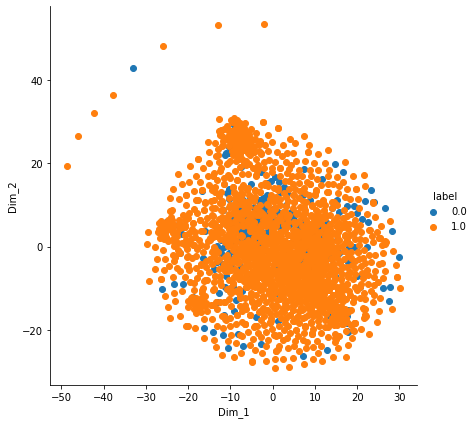

In [12]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_counts[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]

model = TSNE(n_components=2, random_state=0,perplexity = 20,n_iter=500,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

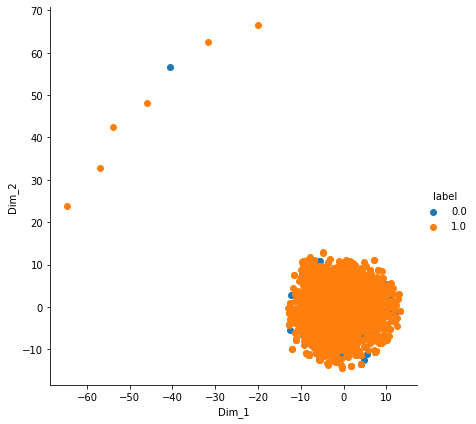

In [13]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_counts[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]

model = TSNE(n_components=2, random_state=0,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

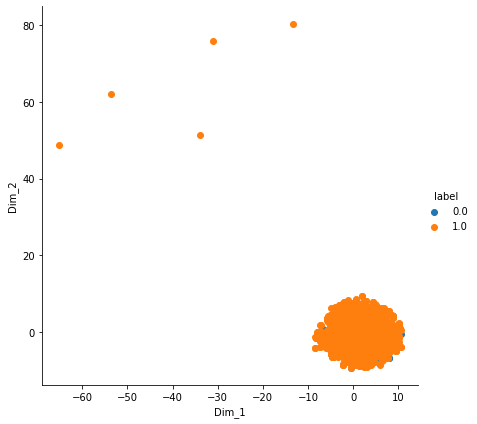

In [14]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_counts[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]

model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=2000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

# [7.2.5] TF-IDF

In [22]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (25000, 19579)
the number of unique words including both unigrams and bigrams  19579


In [23]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[1000:1010])

some sample features(unique words in the corpus) ['assimil', 'assist', 'associ', 'assort', 'asst', 'assuag', 'assum', 'assumpt', 'assur', 'asterisk']


In [24]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

top_tfidf

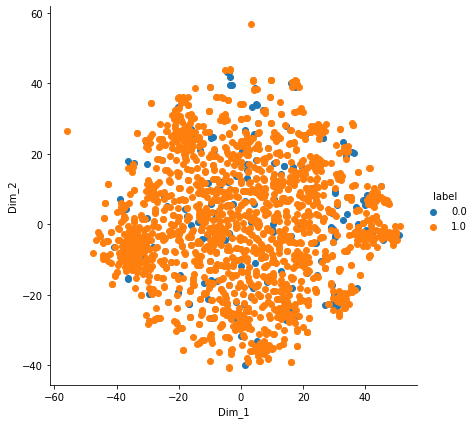

In [25]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_tf_idf[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]
model = TSNE(n_components=2, random_state=0,perplexity = 20,n_iter=500,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

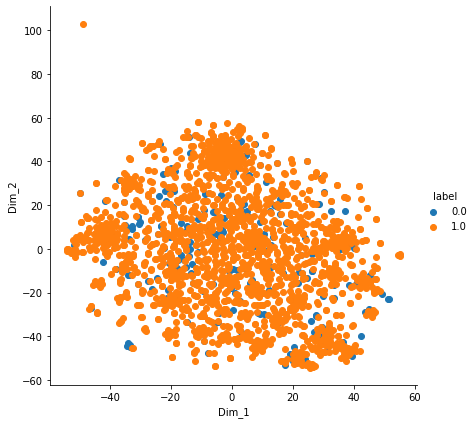

In [26]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_tf_idf[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

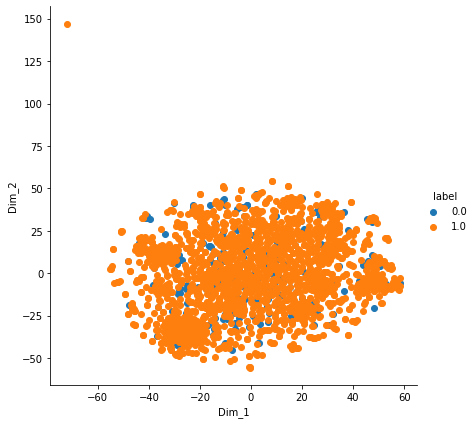

In [27]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
data_2000 = final_tf_idf[0:2000,:].todense()
labels_2000 = final["Score"][0:2000]
model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=2000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

# [7.2.6] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [29]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

simpli put beetlejuic funniest comedi kind sinc ghostbust michael keaton play titl charact fun love ghost like mischief beetlejuic call coupl davi baldwin get rid peopl live thier hous
*****************************************************************
['simpli', 'put', 'beetlejuic', 'funniest', 'comedi', 'kind', 'sinc', 'ghostbust', 'michael', 'keaton', 'play', 'titl', 'charact', 'fun', 'love', 'ghost', 'like', 'mischief', 'beetlejuic', 'call', 'coupl', 'davi', 'baldwin', 'get', 'rid', 'peopl', 'live', 'thier', 'hous']


In [30]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [31]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6847
sample words  ['simpli', 'put', 'beetlejuic', 'kind', 'sinc', 'michael', 'keaton', 'play', 'titl', 'charact', 'fun', 'love', 'ghost', 'like', 'call', 'coupl', 'get', 'rid', 'peopl', 'live', 'thier', 'hous', 'use', 'previous', 'model', 'year', 'happi', 'one', 'downsid', 'earlier', 'offer', 'wine', 'lover', 'never', 'knew', 'vacuum', 'achiev', 'make', 'sure', 'damag', 'oxygen', 'bottl', 'got', 'napa', 'month', 'ago', 'glad', 'not', 'deliv', 'promis']


In [32]:
w2v_model.wv.most_similar('tasti')

[('yummi', 0.8532200455665588),
 ('delici', 0.8373256921768188),
 ('satisfi', 0.8049272298812866),
 ('hearti', 0.7947583794593811),
 ('crunch', 0.7691254019737244),
 ('nutriti', 0.7381624579429626),
 ('crunchi', 0.7379350662231445),
 ('dessert', 0.7163292169570923),
 ('dens', 0.7141882181167603),
 ('incred', 0.7132158279418945)]

In [33]:
w2v_model.wv.most_similar('like')

[('prefer', 0.6960845589637756),
 ('weird', 0.6875526905059814),
 ('aw', 0.677577793598175),
 ('appeal', 0.6592475175857544),
 ('funni', 0.6556658148765564),
 ('terribl', 0.6500604152679443),
 ('odd', 0.6400692462921143),
 ('dislik', 0.6374333500862122),
 ('real', 0.6365963220596313),
 ('nasti', 0.6296987533569336)]

# [7.2.7] Avg W2V, TFIDF-W2V

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 25000/25000 [01:14<00:00, 337.24it/s]

25000
50


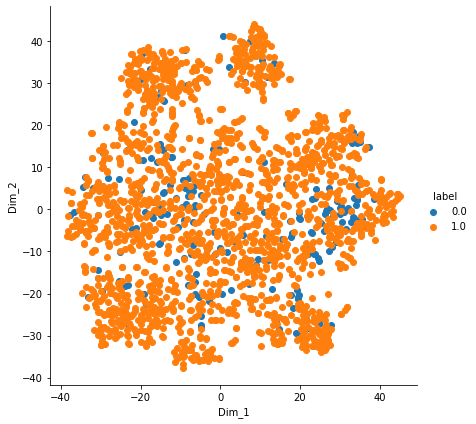

In [35]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_2000 = sent_vectors[0:2000]
labels_2000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0,perplexity = 20,n_iter=500,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

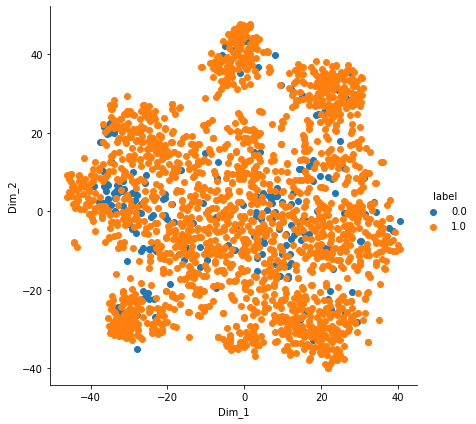

In [36]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_2000 = sent_vectors[0:2000]
labels_2000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

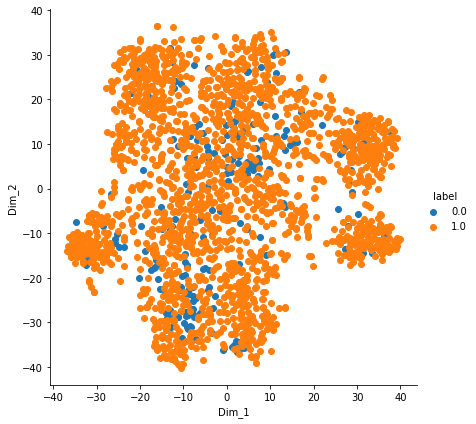

In [37]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_2000 = sent_vectors[0:2000]
labels_2000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=2000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

In [38]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 25000/25000 [00:47<00:00, 528.52it/s]


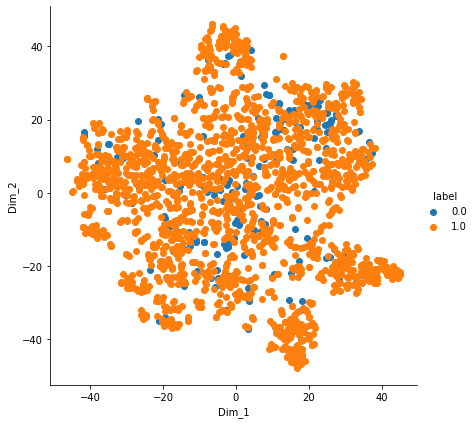

In [40]:

# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_1000 = tfidf_sent_vectors[0:2000]
labels_1000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0,perplexity = 20,n_iter=500,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

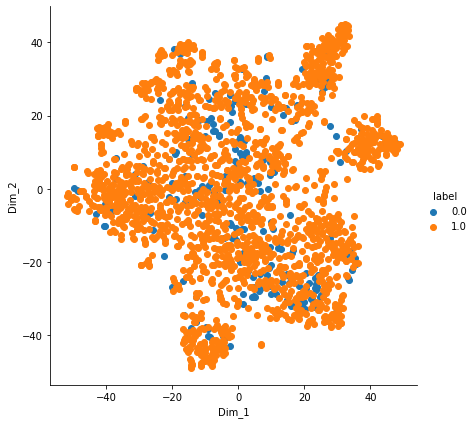

In [41]:

# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_1000 = tfidf_sent_vectors[0:2000]
labels_1000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

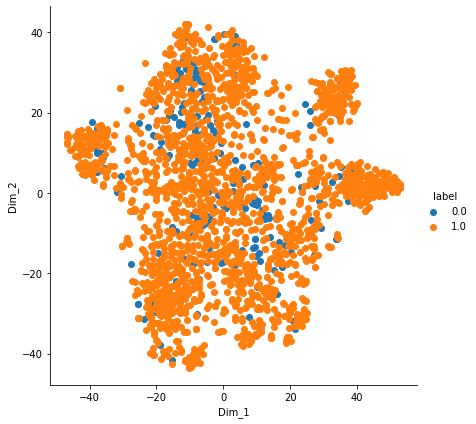

In [42]:

# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_1000 = tfidf_sent_vectors[0:2000]
labels_1000 = final["Score"][0:2000]

TSNE_model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=2000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
#plt.title('With perplexity = 50')
plt.show()

# Observations

## tsne plot analysis

1.Bow:by observing above plots we conclude that as the perplexity and number of iterations increases positive and negative classes are overlapping and they are unreadable.

2.Tf-Idf:observing above plots we conclude that as the perplexity and number of iterations increases the overlapping of both the classes  increases and also the density of classes around the plot tend to decrease and then Increased in later increase of perplexity and iterations.

3.Avg W2v:observing above plots we conclude that as the perplexity and number of iterations increases  the area of covered by the classes on the plot decreased.

4.Tf-idf W2v:observing above plots we conclude that as the perplexity and number of iterations increases    the overlapping of both the classes alsp increases